 # Task 1: LLM Decoding Strategy Analysis



 This notebook implements Task 1 of the assignment: comparative analysis of four fundamental

 LLM decoding strategies on `SmolLM2-135M-SFT-Only`.



 Strategies Implemented from Scratch:

 1. Greedy Search

 2. Beam Search

 3. Top-K Sampling

 4. Top-P (Nucleus) Sampling

In [1]:
# !pip install torch transformers datasets pandas matplotlib tqdm numpy

In [2]:
# ============================================
# 📦 Imports and Environment Setup
# ============================================
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import load_dataset
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Directory Setup
RESULTS_DIR = "task1_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


 ## Load Models

In [3]:
# ============================================
# 🧠 Load SFT Model and Reward Model
# ============================================
model_name = "HuggingFaceTB/smollm2-135M-SFT-Only"

print("Loading SFT Model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16, # Optimized for memory
    device_map="auto"
)
model.eval()

# Load a Reward Model for Quality Evaluation (Task 1 requirement)
# Using a small, efficient Reward Model available on HF for scoring
rm_name = "OpenAssistant/reward-model-deberta-v3-base" 
print(f"Loading Reward Model ({rm_name})...")
try:
    reward_tokenizer = AutoTokenizer.from_pretrained(rm_name)
    reward_model = AutoModelForSequenceClassification.from_pretrained(
        rm_name, 
        device_map="auto",
        dtype=torch.float16
    )
    reward_model.eval()
except Exception as e:
    print(f"⚠️ Could not load specific Reward Model: {e}")
    print("Will use a placeholder scorer (length-based) for demonstration.")
    reward_model = None

print("✅ Models Loaded.")


Loading SFT Model...
Loading Reward Model (OpenAssistant/reward-model-deberta-v3-base)...
✅ Models Loaded.


 ## Decoding Strategy Implementations

 Implemented manually using logit manipulation as per assignment instructions [cite: 84-100].

In [4]:
def get_next_token_logits(model, input_ids):
    """Helper to get logits for the last token."""
    with torch.no_grad():
        outputs = model(input_ids)
    return outputs.logits[0, -1, :]

def greedy_search(model, tokenizer, prompt, max_new_tokens=50):
    """
    Implements Greedy Search: Select token with highest probability.
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated = input_ids

    for _ in range(max_new_tokens):
        logits = get_next_token_logits(model, generated)
        next_token = torch.argmax(logits).unsqueeze(0).unsqueeze(0) # Argmax operation
        
        generated = torch.cat((generated, next_token), dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
            
    return tokenizer.decode(generated[0], skip_special_tokens=True)

def beam_search(model, tokenizer, prompt, max_new_tokens=50, beam_width=3):
    """
    Implements Beam Search: Maintains B most promising sequences.
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    # List of tuples: (score (log_prob), sequence_tensor)
    beams = [(0.0, input_ids)] 
    
    completed_beams = []

    for _ in range(max_new_tokens):
        candidates = []
        
        # Expand all current beams [cite: 89]
        for score, seq in beams:
            # If this beam already ended, don't expand
            if seq[0, -1].item() == tokenizer.eos_token_id:
                completed_beams.append((score, seq))
                continue
                
            logits = get_next_token_logits(model, seq)
            log_probs = F.log_softmax(logits, dim=-1) # Log probabilities
            
            # Optimization: Only look at top B candidates per beam to save compute
            top_scores, top_indices = torch.topk(log_probs, beam_width)
            
            for i in range(beam_width):
                next_score = score + top_scores[i].item() # Cumulative log-prob [cite: 90]
                next_seq = torch.cat((seq, top_indices[i].unsqueeze(0).unsqueeze(0)), dim=1)
                candidates.append((next_score, next_seq))
        
        # Sort all candidates by score and keep top B [cite: 91]
        beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]
        
        # Early exit if all beams are finished (simplification)
        if all(b[1][0, -1].item() == tokenizer.eos_token_id for b in beams):
            completed_beams.extend(beams)
            break
    
    # If completed_beams is empty (max length reached), use current beams
    if not completed_beams:
        completed_beams = beams
        
    # Return sequence with highest score [cite: 92]
    best_score, best_seq = max(completed_beams, key=lambda x: x[0])
    return tokenizer.decode(best_seq[0], skip_special_tokens=True)

def top_k_sampling(model, tokenizer, prompt, max_new_tokens=50, k=50, temperature=1.0):
    """
    Implements Top-K Sampling: Samples from top K tokens.
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated = input_ids

    for _ in range(max_new_tokens):
        logits = get_next_token_logits(model, generated)
        
        # Apply Temperature [cite: 95]
        logits = logits / temperature
        
        # Filter to Top K
        top_k_logits, top_k_indices = torch.topk(logits, k)
        
        # Create a mask of -inf for non-top-k
        mask = torch.full_like(logits, float('-inf'))
        mask.scatter_(0, top_k_indices, top_k_logits)
        
        # Softmax to get probabilities [cite: 96]
        probs = F.softmax(mask, dim=-1)
        
        # Sample stochastically [cite: 97]
        next_token = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        
        generated = torch.cat((generated, next_token), dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
            
    return tokenizer.decode(generated[0], skip_special_tokens=True)

def top_p_sampling(model, tokenizer, prompt, max_new_tokens=50, p=0.9, temperature=1.0):
    """
    Implements Nucleus (Top-P) Sampling: Dynamic nucleus selection.
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated = input_ids

    for _ in range(max_new_tokens):
        logits = get_next_token_logits(model, generated)
        logits = logits / temperature
        
        # Sort logits descending
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        
        # Remove tokens with cumulative probability above the threshold
        # Shift mask right to keep the first token above threshold
        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        
        # Scatter indices back to original positions
        indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
        
        # Set removed logits to -inf
        logits[indices_to_remove] = float('-inf')
        
        # Sample from re-normalized distribution [cite: 99]
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        
        generated = torch.cat((generated, next_token), dim=1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
            
    return tokenizer.decode(generated[0], skip_special_tokens=True)


 ## Metrics Implementation

In [5]:
def calculate_distinct_n(texts, n):
    """
    Calculates Distinct-N metric: Unique N-grams / Total N-grams[cite: 103].
    """
    total_ngrams = 0
    unique_ngrams = set()
    
    for text in texts:
        words = text.split()
        if len(words) < n:
            continue
        # Generate N-grams
        ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        unique_ngrams.update(ngrams)
        total_ngrams += len(ngrams)
        
    if total_ngrams == 0: return 0.0
    return len(unique_ngrams) / total_ngrams

def get_reward_score(text, reward_model, reward_tokenizer):
    """
    Scores generation using the loaded Reward Model.
    """
    if reward_model is None:
        return 0.0 # Fallback
        
    inputs = reward_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
    return outputs.logits[0].item()


 ## Experiment Setup

 Load dataset and define prompt set.

In [6]:
print("Loading Dataset...")
dataset = load_dataset("Intel/orca_dpo_pairs", split="train")

# Select 10 diverse prompts for the temperature sweep
# And 1 specific prompt for Within-Prompt Diversity
prompts = dataset.select(range(10))['question']
fixed_prompt = prompts[0]

print(f"Loaded {len(prompts)} prompts for general analysis.")
print(f"Fixed prompt for diversity test: '{fixed_prompt[:50]}...'")


Loading Dataset...
Loaded 10 prompts for general analysis.
Fixed prompt for diversity test: 'You will be given a definition of a task first, th...'


 ## Experiment 1: Temperature Sweep (Top-K & Top-P)

 Investigating trade-offs between generation quality and diversity[cite: 101].

🚀 Starting Temperature Sweep...


Temperatures: 100%|██████████| 5/5 [06:07<00:00, 73.44s/it]



Temperature Sweep Results:
         Strategy Temperature  Distinct-1  Distinct-2  Distinct-3  Avg Reward
0          Greedy         N/A    0.494390    0.896760    0.973424   -3.178931
1      Beam (B=3)         N/A    0.499622    0.905560    0.983116   -2.934497
2    Top-K (K=50)         0.2    0.483309    0.885965    0.966863   -3.200806
3   Top-P (P=0.9)         0.2    0.483309    0.885965    0.966863   -3.200806
4          Greedy         N/A    0.494390    0.896760    0.973424   -3.178931
5      Beam (B=3)         N/A    0.499622    0.905560    0.983116   -2.934497
6    Top-K (K=50)         0.5    0.490110    0.895203    0.975465   -3.463599
7   Top-P (P=0.9)         0.5    0.487217    0.893304    0.973314   -3.389380
8          Greedy         N/A    0.494390    0.896760    0.973424   -3.178931
9      Beam (B=3)         N/A    0.499622    0.905560    0.983116   -2.934497
10   Top-K (K=50)         0.8    0.486272    0.886463    0.968475   -3.919995
11  Top-P (P=0.9)         0.8    0.4

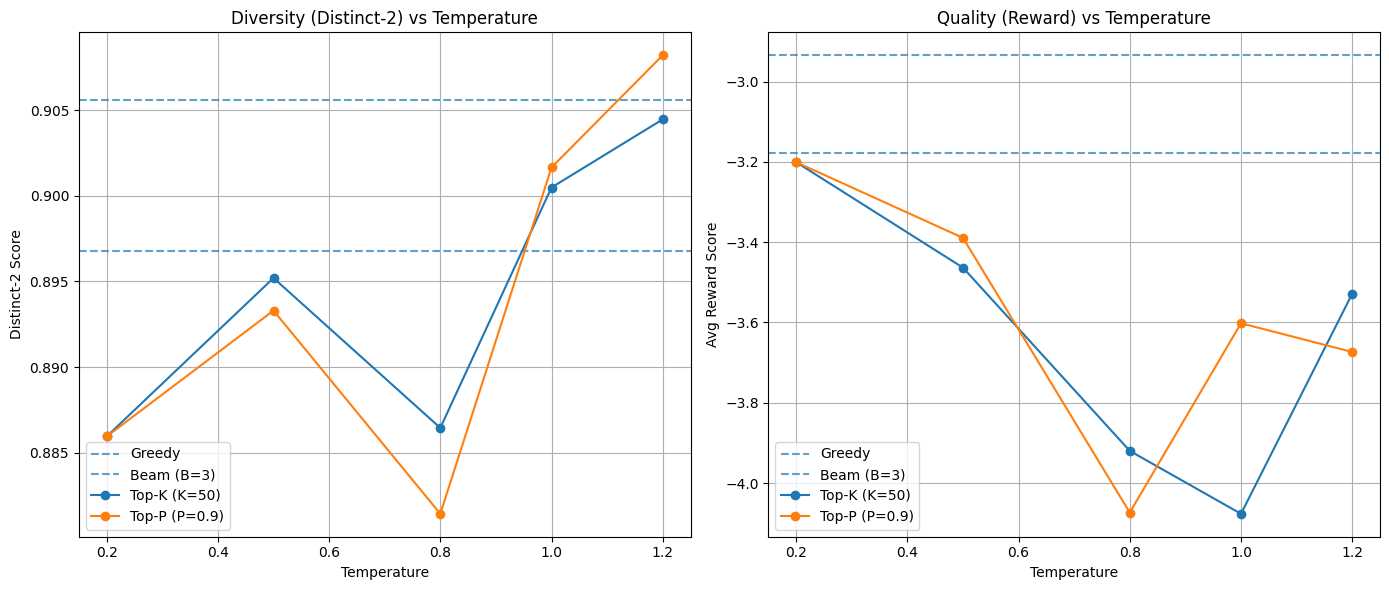

In [7]:
temperatures = [0.2, 0.5, 0.8, 1.0, 1.2]
results = []

print("🚀 Starting Temperature Sweep...")

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# We iterate through ALL strategies (including non-temperature ones for comparison)
strategies = [
    ("Greedy", lambda m, t, p: greedy_search(m, t, p)),
    ("Beam (B=3)", lambda m, t, p: beam_search(m, t, p, beam_width=3)),
    ("Top-K (K=50)", lambda m, t, p: top_k_sampling(m, t, p, k=50, temperature=temp)),
    ("Top-P (P=0.9)", lambda m, t, p: top_p_sampling(m, t, p, p=0.9, temperature=temp)),
]

for temp in tqdm(temperatures, desc="Temperatures"):
    for strategy_name, strategy_fn in strategies:
        generated_texts = []
        rewards = []

        # Set seed for reproducibility in sampling
        torch.manual_seed(42)
        np.random.seed(42)

        for prompt in prompts:
            # Generate
            output = strategy_fn(model, tokenizer, prompt)
            generated_texts.append(output)

            # Score Quality
            reward = get_reward_score(output, reward_model, reward_tokenizer)
            rewards.append(reward)

        # Calculate Metrics
        dist_1 = calculate_distinct_n(generated_texts, 1)
        dist_2 = calculate_distinct_n(generated_texts, 2)
        dist_3 = calculate_distinct_n(generated_texts, 3)
        avg_reward = np.mean(rewards)

        results.append(
            {
                "Strategy": strategy_name,
                "Temperature": (
                    temp
                    if "Top-K" in strategy_name or "Top-P" in strategy_name
                    else "N/A"
                ),
                "Distinct-1": dist_1,
                "Distinct-2": dist_2,
                "Distinct-3": dist_3,
                "Avg Reward": avg_reward,
            }
        )

df_results = pd.DataFrame(results)
print("\nTemperature Sweep Results:")
print(df_results)

# Plotting the Trade-off [cite: 108]
plt.figure(figsize=(14, 6))

# Plot 1: Diversity vs Temperature
plt.subplot(1, 2, 1)
for strategy in df_results["Strategy"].unique():
    subset = df_results[df_results["Strategy"] == strategy]
    # Filter out N/A temperatures for Greedy/Beam
    subset_numeric = subset[subset["Temperature"] != "N/A"]
    if len(subset_numeric) == 0:  # Deterministic strategies (Greedy/Beam)
        plt.axhline(
            y=subset["Distinct-2"].iloc[0], label=strategy, linestyle="--", alpha=0.7
        )
    else:  # Stochastic strategies (Top-K/Top-P)
        plt.plot(
            subset_numeric["Temperature"],
            subset_numeric["Distinct-2"],
            marker="o",
            label=strategy,
        )
plt.title("Diversity (Distinct-2) vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Distinct-2 Score")
plt.legend()
plt.grid(True)

# Plot 2: Quality vs Temperature
plt.subplot(1, 2, 2)
for strategy in df_results["Strategy"].unique():
    subset = df_results[df_results["Strategy"] == strategy]
    # Filter out N/A temperatures for Greedy/Beam
    subset_numeric = subset[subset["Temperature"] != "N/A"]
    if len(subset_numeric) == 0:  # Deterministic strategies (Greedy/Beam)
        plt.axhline(
            y=subset["Avg Reward"].iloc[0], label=strategy, linestyle="--", alpha=0.7
        )
    else:  # Stochastic strategies (Top-K/Top-P)
        plt.plot(
            subset_numeric["Temperature"],
            subset_numeric["Avg Reward"],
            marker="o",
            label=strategy,
        )
plt.title("Quality (Reward) vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Avg Reward Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "temp_tradeoff.png"), dpi=300)
plt.show()

 ## Experiment 2: Fixed Temperature Diversity Analysis

 Comparing all 4 strategies at T=0.8 (for sampling)[cite: 109].

In [8]:
print("\n🚀 Starting Diversity Analysis (Across vs Within Prompt)...")

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

fixed_temp = 0.8
N_SAMPLES = 5  # Note: Greedy/Beam will produce identical samples (Distinct-N ≈ 0)

# Define all strategies
all_strategies = {
    "Greedy": lambda p: greedy_search(model, tokenizer, p),
    "Beam (B=3)": lambda p: beam_search(model, tokenizer, p, beam_width=3),
    "Top-K (K=50)": lambda p: top_k_sampling(
        model, tokenizer, p, k=50, temperature=fixed_temp
    ),
    "Top-P (P=0.9)": lambda p: top_p_sampling(
        model, tokenizer, p, p=0.9, temperature=fixed_temp
    ),
}

diversity_results = []

for strat_name, strat_fn in tqdm(all_strategies.items(), desc="Strategies"):

    # 1. Across-Prompt Diversity [cite: 110]
    # Generate one sample for N different prompts
    across_outputs = []
    for prompt in prompts[:N_SAMPLES]:
        across_outputs.append(strat_fn(prompt))
    across_dist_2 = calculate_distinct_n(across_outputs, 2)

    # 2. Within-Prompt Diversity [cite: 111]
    # Generate N samples for a SINGLE fixed prompt
    within_outputs = []
    for _ in range(N_SAMPLES):
        # Note: Greedy and Beam are deterministic, so Distinct-N will be low/zero for them here
        within_outputs.append(strat_fn(fixed_prompt))
    within_dist_2 = calculate_distinct_n(within_outputs, 2)

    diversity_results.append(
        {
            "Strategy": strat_name,
            "Across-Prompt Distinct-2": across_dist_2,
            "Within-Prompt Distinct-2": within_dist_2,
        }
    )

df_diversity = pd.DataFrame(diversity_results)
print("\nDiversity Analysis Results (T=0.8):")
print(df_diversity)

# Save final report
df_results.to_csv(os.path.join(RESULTS_DIR, "temperature_sweep.csv"), index=False)
df_diversity.to_csv(os.path.join(RESULTS_DIR, "diversity_analysis.csv"), index=False)
print(f"\n✅ Task 1 Complete. Results saved to {RESULTS_DIR}")


🚀 Starting Diversity Analysis (Across vs Within Prompt)...


Strategies: 100%|██████████| 4/4 [01:37<00:00, 24.44s/it]


Diversity Analysis Results (T=0.8):
        Strategy  Across-Prompt Distinct-2  Within-Prompt Distinct-2
0         Greedy                  0.915556                  0.165217
1     Beam (B=3)                  0.942661                  0.182258
2   Top-K (K=50)                  0.907527                  0.237624
3  Top-P (P=0.9)                  0.924612                  0.214804

✅ Task 1 Complete. Results saved to task1_results
